# Post Exploratory Data Analysis


Try to find out why model can't get correct prediction on some dermoscopic images, and based on what information we get from this EDA, we can modify our model and senario to fit more on HAM10000 dataset.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

from src.utils import generate_meta, stratified_split

import matplotlib.pylab as plt
import seaborn as sns
colors = sns.color_palette()

%matplotlib inline

In [2]:
PATH = '/disk/HAM10000/'
MODEL = 'se_resnext50_32x4d'
VERSION = 5


# Get wrong predicted valid_ids
df = generate_meta(PATH)
valid_data = np.load(f'./experiments/{MODEL}_v{VERSION}/results_confusion.npy')
valid_ids, _, preds = valid_data
df = df.loc[df['image_id'].isin(valid_ids)]
df['image_id'] = df['image_id'].astype('category').cat.set_categories(valid_ids)
df = df.sort_values(['image_id'])
df['pred'] = np.array(preds, dtype=np.int8)
wrong_df = df.loc[df['target'] != df['pred']]
right_df = df.loc[df['target'] == df['pred']]
wrong_df.drop(['path'], axis=1).head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,target,pred
11,HAM_0004234,ISIC_0029396,bkl,histo,85.0,female,chest,2,5
17,HAM_0001601,ISIC_0031029,bkl,histo,75.0,male,upper extremity,2,5
44,HAM_0007409,ISIC_0029687,bkl,histo,50.0,male,upper extremity,2,5
45,HAM_0007409,ISIC_0025642,bkl,histo,50.0,male,upper extremity,2,5
53,HAM_0001221,ISIC_0029301,bkl,histo,45.0,male,upper extremity,2,5


## Compare the wrong prediction with correct prediction

1. On the following plot, three on the left dermoscopic images are the wrong prediction made by __<font color=red>5th version of se-resnext50 (32x4d) </font>__, and three on the right is correct. (We are not going to focus on the correct images, they are only use for contrast)


2. Some of the images in `bkl`, `mel` and `nv` are so similar, not sure it's mislabeled or wrong prediction. 


3. Two on the right wrong classified `bcc` are obviously unlike other `bcc` labeled images. Maybe we should check the `bcc` labeled images in training data.


4. There's only one wrong prediction in label `vasc`!

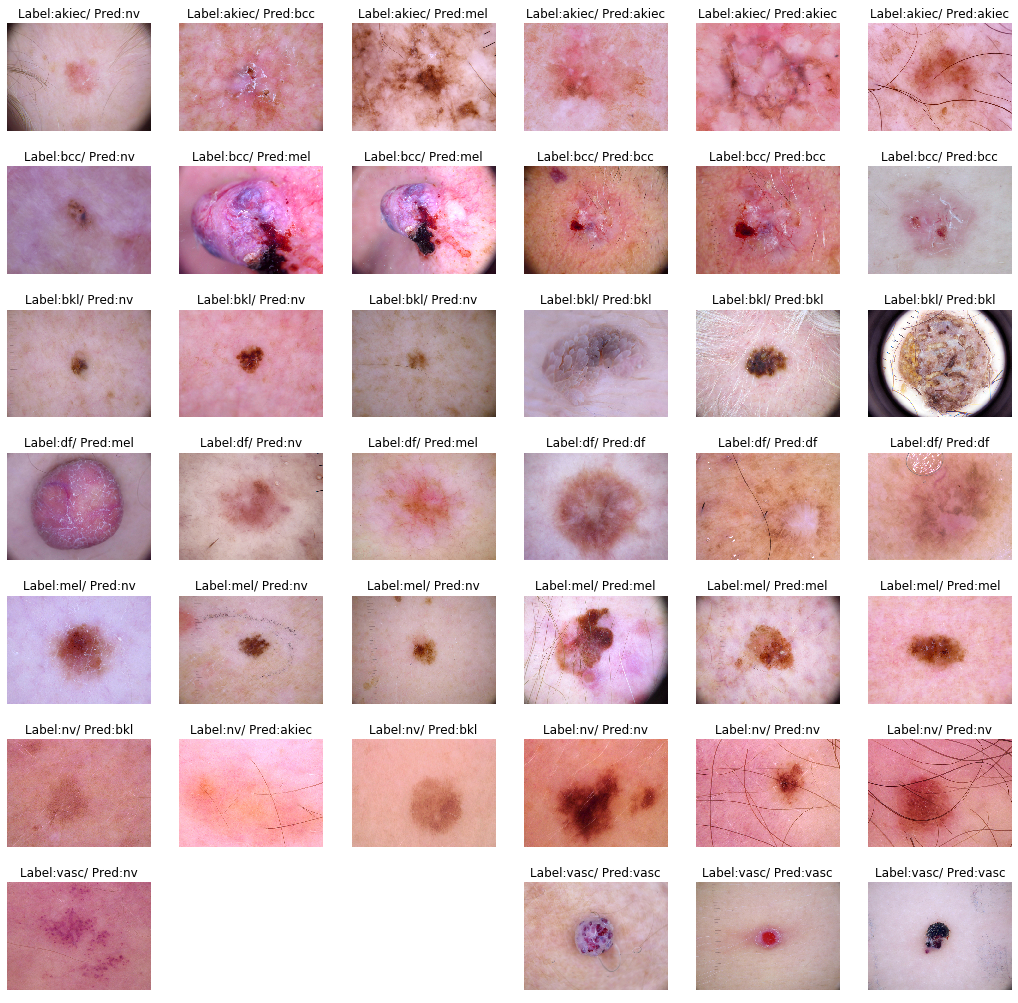

In [3]:
n_samples = 3
classes = dict(df.groupby('dx')['target'].mean())
mapping = {v:k for k, v in classes.items()}


fig, ax = plt.subplots(len(classes), n_samples*2, figsize = (6*n_samples, 18))
for c, k in classes.items():
    for j in range(n_samples):
        # Plot wrong prediction images
        if j+1 > len(wrong_df.loc[df['dx']==c]):
            pass
        else:
            row = wrong_df.loc[df['dx']==c].iloc[j]
            l, p = row['target'], row['pred']
            ax[k][j].set_title(f'Label:{mapping[l]}/ Pred:{mapping[p]}')
            img = cv2.imread(row['path'])
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            ax[k][j].imshow(img)
        ax[k][j].axis('off')
        # Plot correct prediction to compare with wrong one
        row = right_df.loc[df['dx']==c].iloc[j+4]
        l, p = row['target'], row['pred']
        ax[k][j+n_samples].set_title(f'Label:{mapping[l]}/ Pred:{mapping[p]}')
        img = cv2.imread(row['path'])
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        ax[k][j+n_samples].imshow(img)
        ax[k][j+n_samples].axis('off')

## More wrong classified images

1. I can't tell the difference between `nv`, `mel` and `bkl`

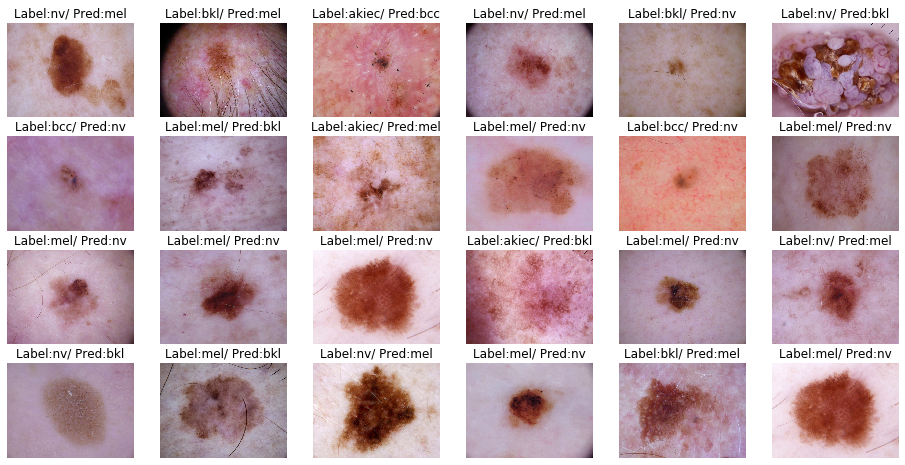

In [4]:
row, col = 0, 0
fig, ax = plt.subplots(4, 6, figsize = (16, 8))
for i in range(24):
    # Plot wrong prediction images
    item = wrong_df.sample(n=1).iloc[0]
    l, p = item['target'], item['pred']
    ax[row][col].set_title(f'Label:{mapping[l]}/ Pred:{mapping[p]}')
    img = cv2.imread(item['path'])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ax[row][col].imshow(img)
    ax[row][col].axis('off')
    col += 1
    if col == 6:
        row, col = row+1, 0